# Train DECiSION

## Set seeds and import packages

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import DECiSION_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.utils.image import standardise, standardise_single, mean_subtraction
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_training_history
from dltoolkit.io import HDF5Writer, HDF5Reader, HDF5Generator_Segment

from thesis_common import convert_img_to_pred, convert_pred_to_img #convert_to_hdf5, group_images
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data conversion functions

In [5]:
def create_hdf5_db(imgs_list, dn_name, img_path, img_shape, key, ext, settings, is_mask=False):
    """
    Create a HDF5 file using a list of paths to individual images to be written to the data set
    :param imgs_list: list of image paths
    :param dn_name: becomes part of the HDF5 file name
    :param img_path: path to the location of the `images` and `groundtruths` subfolders
    :param img_shape: shape of the images being written to the data set
    :param key: key to use for the data set
    :param ext: extension of the HDF5 file name
    :param settings: holds settings
    :param is_mask: True if masks are being written, False if not
    :return: the full path to the HDF5 file
    """
    # Construct the name of the database
    tmp_name = dn_name + ("_masks" if is_mask else "_imgs")
    output_path = os.path.join(os.path.dirname(img_path), tmp_name) + ext
    print(output_path)

    # Prepare the HDF5 writer, which expects a label vector. Because this is a segmentation problem just pass None
    # hdf5_writer = HDF5Writer((len(imgs_list), img_shape[0], img_shape[1], img_shape[2]), output_path,
    hdf5_writer = HDF5Writer(((len(imgs_list),) + img_shape),
                             output_path=output_path,
                             feat_key=key,
                             label_key=None,
                             del_existing=True,
                             buf_size=len(imgs_list),
                             dtype_feat=np.float32 if not is_mask else np.uint8
                             )

    classcounts = [0] * settings.NUM_CLASSES

    # Loop through all images
    widgets = ["Creating HDF5 database ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(imgs_list), widgets=widgets).start()
    for i, img in enumerate(imgs_list):
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

        # Apply binary thresholding to ground truth masks
        if is_mask:
            _, image = cv2.threshold(image, settings.MASK_BINARY_THRESHOLD, settings.MASK_BLOODVESSEL, cv2.THRESH_BINARY)

            # Convert to the format produced by the model
            # print(image.shape)
            # print(np.array([image]).shape)
            # image = convert_img_to_pred(np.array([image]), settings, settings.VERBOSE)

            for ix, cl in enumerate([settings.MASK_BACKGROUND, settings.MASK_BLOODVESSEL]):
                classcounts[ix] += len(np.where(image == cl)[0])
        else:
            # Apply preprocessing to images (not to ground truth masks)
            # print("before, min {} max {}".format(np.min(image), np.max(image)))
            # print("Max prior: {}".format(np.max(image)))
            # image = standardise_single(image)
            # image = mean_subtraction(image)
            # print("Max after: {}".format(np.max(image)))
            # print(" after, min {} max {}".format(np.min(image), np.max(image)))
            pass

        # Reshape from (height, width) to (height, width, 1)
        image = image.reshape((img_shape[0], img_shape[1], img_shape[2]))

        if not is_mask:
        #     image = standardise_single(image)
            image = mean_subtraction(image)
            # image=image/255.

        hdf5_writer.add([image], None)
        pbar.update(i)

    if is_mask:
        total = sum(classcounts)
        for i in range(settings.NUM_CLASSES):
            classcounts[i] = int(total / classcounts[i])

    pbar.finish()
    hdf5_writer.close()

    if is_mask:
        return output_path#, classcounts
    else:
        return output_path


def perform_hdf5_conversion(settings):
    # Prepare the path to the training images and ground truths
    img_exts = ".jpg"
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])
    test_imgs = sorted(list(list_images(basePath=test_path, validExts=img_exts)))

    # Obtain a list of paths to the training images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Split the training set into a training and validation set
    train_img, val_img, train_msk, val_msk = train_test_split(img_list, msk_list,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)

    print("Check train data: {} = {}".format(train_img[0], train_msk[0]))
    print("  Check val data: {} = {}".format(val_img[0], val_msk[0]))
    print("Num train: {}, num val: {}".format(len(train_img), len(val_img)))

    # Create the HDF5 data sets
    output_paths = []

    # Training images
    output_paths.append(create_hdf5_db(train_img, "train", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Training ground truths
    output_paths.append(create_hdf5_db(train_msk, "train", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Validation images
    output_paths.append(create_hdf5_db(val_img, "val", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Validation ground truths
    output_paths.append(create_hdf5_db(val_msk, "val", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Test images (no ground truths available, no need to split)
    output_paths.append(create_hdf5_db(test_imgs, "test", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                        settings=settings))

    return output_paths

## Pre-processing functions

In [6]:
def read_preprocess_image(image_path, key, is_3D=False):
    """Perform image pre-processing, resulting pixel values are between 0.0 and 1.0"""
    imgs = HDF5Reader().load_hdf5(image_path, key)
    print("Loading image HDF5: {} with dtype = {}\n".format(image_path, imgs.dtype))

    # Permute array dimensions for the 3D U-Net model so that the shape becomes: (-1, height, width, slices, channels)
    if is_3D:
        # Standardise
        # print("prior group std during READ:{} - {}".format(imgs.shape, imgs.dtype))
        imgs = standardise(imgs)
        # imgs = mean_subtraction(imgs)
        # print("after group std during READ:{} - {}".format(imgs.shape, imgs.dtype))

        imgs = np.transpose(imgs, axes=(0, 2, 3, 1, 4))

    return imgs


def read_preprocess_groundtruth(ground_truth_path, key, is_3D=False):
    """Perform ground truth image pre-processing, resulting pixel values are between 0 and 255"""
    imgs = HDF5Reader().load_hdf5(ground_truth_path, key).astype("uint8")
    print("Loading ground truth HDF5: {} with dtype = {}\n".format(ground_truth_path, imgs.dtype))

    # Permute array dimensions for the 3D U-Net model so that the shape becomes: (-1, height, width, slices, channels)
    if is_3D:
        imgs = np.transpose(imgs, axes=(0, 2, 3, 1, 4))

    return imgs

## Load and preprocess images

In [7]:
if settings.IS_DEVELOPMENT:
    print("\n--- Converting images to HDF5")
    hdf5_paths = perform_hdf5_conversion(settings)
else:
    # During development avoid performing HDF5 conversion for every run
    hdf5_paths = ["../data/MSC8002/training/train_imgs.h5",
                  "../data/MSC8002/training/train_masks.h5",
                  "../data/MSC8002/training/val_imgs.h5",
                  "../data/MSC8002/training/val_masks.h5"
                  "../data/MSC8002/test/test_imgs.h5"
                  ]

# Read the training images and ground truths
print("\n--- Read and preprocess images")
train_imgs = read_preprocess_image(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_preprocess_groundtruth(hdf5_paths[1], settings.HDF5_KEY)
val_imgs = read_preprocess_image(hdf5_paths[2], settings.HDF5_KEY)
val_grndtr = read_preprocess_groundtruth(hdf5_paths[3], settings.HDF5_KEY)

Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database  26% |#########                          | ETA:  0:00:00


--- Converting images to HDF5
Check train data: ../data/MSC8002/training/images/patient_1/S572080079.jpg = ../data/MSC8002/training/groundtruths/patient_1/S57208Filter0079.jpg
  Check val data: ../data/MSC8002/training/images/patient_1/S572080077.jpg = ../data/MSC8002/training/groundtruths/patient_1/S57208Filter0077.jpg
Num train: 9, num val: 1
../data/MSC8002/training/train_imgs.h5
../data/MSC8002/training/train_masks.h5
../data/MSC8002/training/val_imgs.h5
../data/MSC8002/training/val_masks.h5
../data/MSC8002/test/test_imgs.h5


Creating HDF5 database 100% |###################################| Time: 0:00:00



--- Read and preprocess images
Loading image HDF5: ../data/MSC8002/training/train_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/train_masks.h5 with dtype = uint8

Loading image HDF5: ../data/MSC8002/training/val_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/val_masks.h5 with dtype = uint8



## Show an image as a test


--- Show TRAIN example image


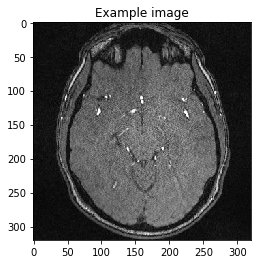

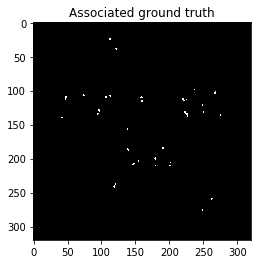

Max image intensity: 0.747138261795044 - -0.25286173820495605 - float32 - (9, 320, 320, 1)
Max grtrh intensity: 255 - 0 - uint8 - (9, 320, 320, 1)

--- Show VAL example image


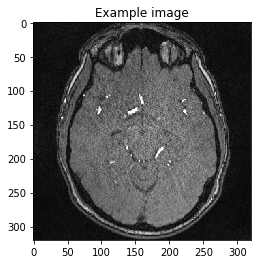

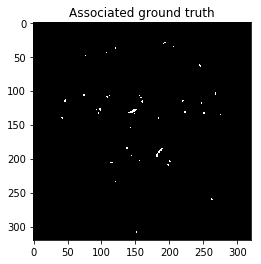

Max image intensity: 0.747138261795044 min: -0.25286173820495605 - float32 - (1, 320, 320, 1)
Max grtrh intensity: 255 min: 0 - uint8 - (1, 320, 320, 1)


In [8]:
# Show one image plus its ground truth as a quick check
print("\n--- Show TRAIN example image")
IX = 0
plt.imshow(np.squeeze(train_imgs[IX]), cmap='gray')
plt.title('Example image')
plt.show()
plt.imshow(np.squeeze(train_grndtr[IX]), cmap='gray')
plt.title('Associated ground truth')
plt.show()
print("Max image intensity: {} - {} - {} - {}".format(np.max(train_imgs[IX]), np.min(train_imgs[IX]),
                                                      train_imgs.dtype, train_imgs.shape))
print("Max grtrh intensity: {} - {} - {} - {}".format(np.max(train_grndtr[IX]), np.min(train_grndtr[IX]),
                                                      train_grndtr.dtype, train_grndtr.shape))

print("\n--- Show VAL example image")
IX = 0
plt.imshow(np.squeeze(val_imgs[IX]), cmap='gray')
plt.title('Example image')
plt.show()
plt.imshow(np.squeeze(val_grndtr[IX]), cmap='gray')
plt.title('Associated ground truth')
plt.show()
print("Max image intensity: {} min: {} - {} - {}".format(np.max(train_imgs[IX]), np.min(train_imgs[IX]),
                                                         val_imgs.dtype, val_imgs.shape))
print("Max grtrh intensity: {} min: {} - {} - {}".format(np.max(train_grndtr[IX]), np.min(train_grndtr[IX]),
                                                         val_grndtr.dtype, val_grndtr.shape))


## Class distribution

In [9]:
# Print class distribution
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

print(train_imgs.shape)

Class distribution: [1.0, 10.0]
(9, 320, 320, 1)


## Create U-Net model

In [10]:
# Instantiate the U-Net model
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)

# model = unet.build_model_sigmoid()
# model = unet.build_model_flatten()
model = unet.build_model_softmax()


## Create paths

In [11]:
# Prepare some path strings
model_path = os.path.join(settings.MODEL_PATH, "DECiSION_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                            settings.TRN_BATCH_SIZE))

## Save/print model architecture information

In [12]:
# Print the architecture to the console, a text file and an image
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "DECiSION_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Convert ground truths

In [13]:
# Convert the ground truths into the same shape as the predictions the U-net produces
print("--- \nEncoding training ground truths")
print("Ground truth shape before conversion: {} of type {}".format(train_grndtr.shape, train_grndtr.dtype))
# train_grndtr_ext_conv = train_grndtr        # no conversion for sigmoid
# val_grndtr_ext_conv = val_grndtr        # no conversion for sigmoid

# train_grndtr_ext_conv = convert_img_to_pred_flatten(train_grndtr, settings, settings.VERBOSE)  # softmax: 3D
# val_grndtr_ext_conv = convert_img_to_pred_flatten(val_grndtr, settings, settings.VERBOSE)  # softmax: 3D

train_grndtr_ext_conv = convert_img_to_pred(train_grndtr, settings, settings.VERBOSE)  # softmax: 4D
val_grndtr_ext_conv = convert_img_to_pred(val_grndtr, settings, settings.VERBOSE)  # softmax: 4D
print(" Ground truth shape AFTER conversion: {} of type {}\n".format(train_grndtr_ext_conv.shape, train_grndtr_ext_conv.dtype))

--- 
Encoding training ground truths
Ground truth shape before conversion: (9, 320, 320, 1) of type uint8
Elapsed time: 1.7543537616729736
Elapsed time: 0.19577813148498535
 Ground truth shape AFTER conversion: (9, 320, 320, 2) of type uint8



## Fit the model

In [14]:
# Train the model
print("\n--- Start training")
# Prepare callbacks
callbacks = [ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
             EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=settings.TRN_EARLY_PATIENCE,
                           verbose=0,
                           mode="auto"),
             CSVLogger(csv_path, append=False),
             ]

# Set the optimiser, loss function and metrics
# opt = Adam()
# metrics = [dice_coef]
# loss = "binary_crossentropy"
opt = Adam()
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile and fit
model.compile(optimizer=opt, loss=loss, metrics=metrics)

# train_gen, train_mask_gen = create_data_generators(train_imgs, train_grndtr, settings.TRN_BATCH_SIZE)
start_time = time.time()

hist = model.fit(train_imgs, train_grndtr_ext_conv,
                 epochs=settings.TRN_NUM_EPOCH,
                 batch_size=settings.TRN_BATCH_SIZE,
                 verbose=1,
                 shuffle=True,
                 # class_weight={0: 0.11, 255: 0.89},
                 validation_data=(val_imgs, val_grndtr_ext_conv),
                 # validation_split=settings.TRN_TRAIN_VAL_SPLIT,
                 callbacks=callbacks)


--- Start training
Train on 9 samples, validate on 1 samples
Epoch 1/100
9/9 [==============================] - 12s 1s/step - loss: 57764.9633 - dice_coef: 0.6085 - val_loss: 29446.8418 - val_dice_coef: 0.9950

Epoch 00001: val_loss improved from inf to 29446.84180, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Epoch 2/100
9/9 [==============================] - 12s 1s/step - loss: 24420.0312 - dice_coef: 0.9255 - val_loss: 18925.1895 - val_dice_coef: 0.8800

Epoch 00002: val_loss improved from 29446.84180 to 18925.18945, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Epoch 3/100
9/9 [==============================] - 12s 1s/step - loss: 17132.0627 - dice_coef: 0.9548 - val_loss: 14100.1113 - val_dice_coef: 0.9473

Epoch 00003: val_loss improved from 18925.18945 to 14100.11133, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Epoch 4/100
9/9 [==============================] - 12s 1s/step - loss: 15698.1896 - dice_co

## Plot the results

In [15]:
plot_training_history(hist,
                      settings.TRN_NUM_EPOCH,
                      show=False,
                      save_path=settings.OUTPUT_PATH + unet.title,
                      time_stamp=True,
                      metric="dice_coef")

print("\n--- Training complete")

print("Elapsed training time: {} min".format(int((time.time() - start_time))/60))


--- Training complete
Elapsed training time: 9.383333333333333 min


## Perform pipeline test


--- Pipeline test


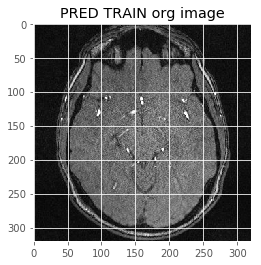

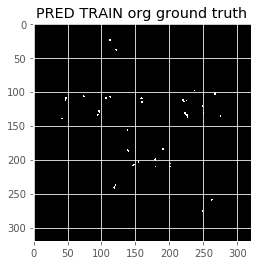

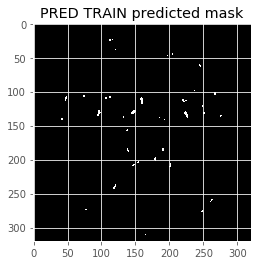

  original 0.747138261795044 dtype float32
  gr truth 255 dtype uint8
prediction 255 dtype uint8


In [16]:
print("\n--- Pipeline test")
# For pipeline testing only, predict on one training image
predictions = model.predict(train_imgs[[0]], batch_size=settings.TRN_BATCH_SIZE, verbose=2)

# predictions = predictions
# predictions = convert_pred_to_img_flatten(predictions, settings.TRN_PRED_THRESHOLD)
predictions = convert_pred_to_img(predictions, settings, settings.TRN_PRED_THRESHOLD)


plt.imshow(np.squeeze(train_imgs[0]), cmap='gray')
plt.title('PRED TRAIN org image')
plt.show()
plt.imshow(np.squeeze(train_grndtr[0]), cmap='gray')
plt.title('PRED TRAIN org ground truth')
plt.show()
plt.imshow(np.squeeze(predictions[0]), cmap='gray')
plt.title('PRED TRAIN predicted mask')
plt.show()

print("  original {} dtype {}".format(np.max(train_imgs[0]), train_imgs[0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0]), train_grndtr[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions[0]), predictions[0].dtype))